# Matrix Factorization
Matrix Factorization is a class of the collaborative filtering algorithm. The end goal of matrix factorization is basically to build a matrix of users and items filled with known and predicted ratings.

Starting with our sparse (and high-dimensional) original matrix of only known ratings, we want to determine the two factor matrices that are much lower in dimensions that would produce our original matrix. One being the matrix that quantitatively represents the users (user matrix) where each row of the matrix is a vector of size *k* that represents a single user, and the other being the item matrix where each column is a vector of size *k* that represents a single item.

![](https://drive.google.com/uc?id=1ZyzVuhcrOA4iYaw69EaBsqPPdLdDqvFW)

The model is learned by fitting the previously observed ratings. However, the goal is to generalize those previous ratings in a way that predicts future/unknown ratings. 

* Accordingly, each item *i* is associated with a vector *q_i*, and each user *u* is associated with a vector *p_u*.
* For a given item *i*, the elements of *q_i* measure the extent to which the item possesses those factors, positive or negative.
* For a given user *u*, the elements of *p_u* measure the extent of interest the user has in items that are high on the corresponding factors, positive or negative.
* The resulting dot product (*q_i* * *p_u*) captures the interaction between user *u* and item *i*, which is the user’s overall interest in the item’s characteristics:

  ![](https://drive.google.com/uc?id=1--ADw7Bmz6fOOwbLAN2Krd4hcfEdH-7d)

* Some users give high ratings than others, and some items received high ratings than others systematically. To capture these biases, user specific and item specific bias terms can be introduced. Thus, we can extend above equation as follows:

  ![](https://drive.google.com/uc?id=1TZ8SmF-Fsrh93U2Ymx1sSgycn7GZEL4v)

* The model is learned by minimizing a squared error function on the set of known ratings, in order to avoid overfitting the observed data we add an L2 regularization penalty to each element and optimize the learned parameters simultaneously with stochastic gradient descent, as seen in equation below:

  ![](https://drive.google.com/uc?id=1C9D1Fd-FvA6hw12SFHN7m3csCeJpVRtX)



# Model implementation in PyTorch

First, we implement the matrix factorization model described above. The user/item latent factors and the user/item biases can be created with the `nn.Embedding. `

In the forward function, user and item ids are used to look up the embeddings.

In [ ]:
# import al necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
torch.manual_seed(2020)

In [ ]:
class MovieLensDataset(Dataset):
  """
  MovieLens dataset class
  """
  def __init__(self, dataset_path, sep='::', engine='python', header=None):
    data = pd.read_csv(dataset_path, sep=sep, engine=engine, header=header)

    # enconde the data to have contiguous ids for users and movies
    lab_enc = LabelEncoder()
    data[0] = lab_enc.fit_transform(data[0])
    data[1] = lab_enc.fit_transform(data[1])
    data = data.to_numpy()[:, :3]

    # retrieve users, movies and ratings data
    self.users = data[:, 0].astype(np.int)
    self.movies = data[:, 1].astype(np.int)
    self.ratings = data[:, 2].astype(np.float32)
    self.num_users = len(np.unique(self.users))
    self.num_movies = len(np.unique(self.movies))
    self.unique_movies = np.unique(self.movies)

  def __len__(self):
    return self.ratings.shape[0]

  def __getitem__(self, idx):
    return self.users[idx], self.movies[idx], self.ratings[idx]

In [ ]:
class MF(nn.Module):
  """
  Matrix Factorization model class
  """
  def __init__(self, n_user, n_item, k_factor, c_bias, c_vector):
    super(MF, self).__init__()

    # These are the hyper-parameters
    self.n_user = n_user
    self.n_item = n_item
    self.k_factor = k_factor
    self.c_bias = c_bias
    self.c_vector = c_vector

    # factor matrices and biases which learned and fit by PyTorch
    self.user_emb = nn.Embedding(self.n_user, k_factor)
    self.movie_emb = nn.Embedding(self.n_item, k_factor)
    self.user_bias = nn.Embedding(self.n_user, 1)
    self.movie_bias = nn.Embedding(self.n_item, 1)        
    self.bias = nn.Parameter(torch.ones(1))

    # initializing our matrices with a positive number generally will yield better results
    self.user_emb.weight.data.uniform_(0, 0.05)
    self.movie_emb.weight.data.uniform_(0, 0.05)
    self.user_bias.weight.data.uniform_(-0.01,0.01)
    self.movie_bias.weight.data.uniform_(-0.01,0.01)  

  def forward(self, user_idx, movie_idx):
    user_vector = self.user_emb(user_idx)
    movie_vector = self.movie_emb(movie_idx)
    bias_user = self.user_bias(user_idx).squeeze()
    bias_movie = self.movie_bias(movie_idx).squeeze()
    biases = (self.bias + bias_user + bias_movie)

    # taking the dot product and adding biases to the prediction
    interaction = torch.sum(user_vector * movie_vector, dim=1)
    prediction = interaction + biases
    return prediction

  def loss(self, prediction, target):
    """
    Function to calculate the loss metric
    """
    # Calculate the Mean Squared Error between target = R_ui and prediction = p_u * q_i
    loss_mse = F.mse_loss(prediction, target.squeeze())

    # Compute L2 regularization over user (P) and item (Q) matrices
    reg_user  = l2_regularize(self.user_emb.weight) * self.c_vector
    reg_movie  = l2_regularize(self.movie_emb.weight) * self.c_vector

    # compute L2 regularization over the biases for user and the biases for item matrices
    prior_bias_user = l2_regularize(self.user_bias.weight) * self.c_bias
    prior_bias_movie = l2_regularize(self.movie_bias.weight) * self.c_bias

    # Add up the MSE loss + user & item regularization
    total_loss = loss_mse + reg_user + reg_movie + prior_bias_user + prior_bias_movie
    return total_loss
    
def l2_regularize(array):
    """
    Function to do L2 regularization
    """
    loss = torch.sum(array ** 2.0)
    return loss

In [ ]:
# create the training function to train the model on training data
def fit(model, optimizer, data_loader, device, log_interval=1000):
    model.train()
    for i, (user, movie, target) in enumerate(data_loader):
        user, movie, target = user.to(device), movie.to(device), target.to(device)
        predicts = model(user, movie)
        loss_mse = model.loss(predicts, target.float())
        model.zero_grad()
        loss_mse.backward()
        optimizer.step()
    return loss_mse.item()

# create the evaluating function to test the model performance on unseen data
def test(model, data_loader, device):
    model.eval()
    with torch.no_grad():
        for user, movie, target in (data_loader):
            user, movie, target = user.to(device), movie.to(device), target.to(device)
            predict = model(user, movie)
            loss_mse = model.loss(predict, target)
    return loss_mse.item()

In [ ]:
# get the data
!wget http://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip

--2021-02-08 06:55:37--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip.1’

ml-1m.zip.1         100%[===================>]   5.64M  19.0MB/s    in 0.3s    

2021-02-08 06:55:37 (19.0 MB/s) - ‘ml-1m.zip.1’ saved [5917549/5917549]

Archive:  ml-1m.zip
replace ml-1m/movies.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
# Get the dataset
dataset = MovieLensDataset('./ml-1m/ratings.dat')
# Split the data into 80% train, 10% validation, and 10% test
train_length = int(len(dataset) * 0.9)
test_length = len(dataset) - train_length
train_dataset, test_dataset = torch.utils.data.random_split(dataset, (train_length, test_length))

# Instantiate data loader classes for train, validation, and test sets
train_data_loader = DataLoader(train_dataset, batch_size=2048, num_workers=8)
test_data_loader = DataLoader(test_dataset, batch_size=2048, num_workers=8)

# Define the Hyper-parameters
lr = 1e-2  # Learning Rate
k_factor = 10  # Number of dimensions per user, item
c_bias = 1e-6  # New parameter for regularizing bias
c_vector = 1e-6  # Regularization constant
epochs = 10 # total number of training epochs
device = 'cpu' # or 'gpu'

# initialize the model
model = MF(dataset.num_users, dataset.num_movies, k_factor=k_factor, c_bias=c_bias, c_vector=c_vector)
print(model)
# initialize the optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

MF(
  (user_emb): Embedding(6040, 10)
  (movie_emb): Embedding(3706, 10)
  (user_bias): Embedding(6040, 1)
  (movie_bias): Embedding(3706, 1)
)


Now let's fit the model, check the loss changes and test the final score on unseen data.

In [ ]:
# Loop through pre-defined number of epochs
train_losses = []
test_losses = []

for epoch in range(epochs):
    # Perform training on the train set
    train_loss = fit(model, optimizer, train_data_loader, device)
    # Perform evaluation on the validation set
    # valid_auc = test(model, valid_data_loader, device)
    # Log the epochs and AUC on the validation set
    print('epoch:', epoch, 'training loss:', train_loss)
    train_losses.append(train_loss)

    # Perform evaluation on the test set
    test_loss = test(model, test_data_loader, device)
    # Log the final MSE loss on the test set
    print('epoch:', epoch, 'testing  loss:', test_loss)
    test_losses.append(test_loss)

# Save the model checkpoint
torch.save(model.state_dict(), 'mf.pt')

epoch: 0 training loss: 0.8833997249603271
epoch: 0 testing  loss: 0.9032543301582336
epoch: 1 training loss: 0.8608534932136536
epoch: 1 testing  loss: 0.8818581700325012
epoch: 2 training loss: 0.8139988780021667
epoch: 2 testing  loss: 0.8444460034370422
epoch: 3 training loss: 0.7552306056022644
epoch: 3 testing  loss: 0.8025814294815063
epoch: 4 training loss: 0.7055177092552185
epoch: 4 testing  loss: 0.782015860080719
epoch: 5 training loss: 0.6720893383026123
epoch: 5 testing  loss: 0.7770520448684692
epoch: 6 training loss: 0.6542090177536011
epoch: 6 testing  loss: 0.7734175324440002
epoch: 7 training loss: 0.6441497206687927
epoch: 7 testing  loss: 0.7706304788589478
epoch: 8 training loss: 0.6378635168075562
epoch: 8 testing  loss: 0.7692248821258545
epoch: 9 training loss: 0.6336599588394165
epoch: 9 testing  loss: 0.7690462470054626


The model perfomence on test data is not that good, even though training loss converges quite well. These can impove the performance:

*   Get more data
*   Tune hyper-patameters



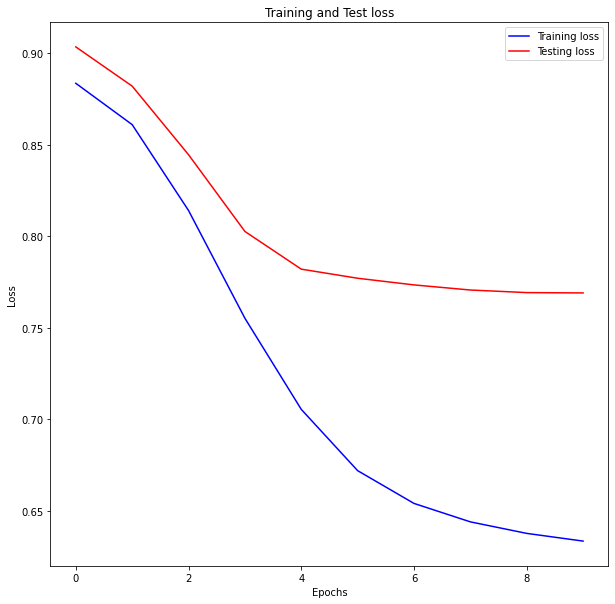

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.plot( train_losses, 'b', label='Training loss')
plt.plot( test_losses, 'r', label='Testing loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Undertanding Embeddings

In [ ]:
user_emb = model.user_emb.weight
movie_emb = model.movie_emb.weight
user_bias = model.user_bias.weight
movie_bias = model.movie_bias.weight

In [ ]:
# show some users and movies with corresponding ratings from our dataset
print(dataset.users)
print(dataset.movies)
print(dataset.ratings)

[   0    0    0 ... 6039 6039 6039]
[1104  639  853 ...  548 1024 1025]
[5. 3. 3. ... 5. 4. 4.]


In [ ]:
# lets check if we can get the original ratings of the first and the last samples using latent vectors
interaction = torch.sum(user_emb[0] * movie_emb[0], dim=0)
biases = model.bias + user_bias[0] + movie_bias[0]
prediction = interaction + biases
print(prediction)

interaction = torch.sum(user_emb[-1] * movie_emb[-1], dim=0)
biases = model.bias + user_bias[-1] + movie_bias[-1]
prediction = interaction + biases
print(prediction)

# or the same can be done using the model itself
prediction = model(torch.tensor([0]),torch.tensor([0]))
print(prediction)
prediction = model(torch.tensor([6039]),torch.tensor([3705]))
print(prediction)

tensor([4.5945], grad_fn=<AddBackward0>)
tensor([3.0533], grad_fn=<AddBackward0>)
tensor([4.5945], grad_fn=<AddBackward0>)
tensor([3.0533], grad_fn=<AddBackward0>)


In [ ]:
# or we can define a small function to predict our original ratings for userId == 5533 
train_df = pd.read_csv('./ml-1m/ratings.dat', sep='::', engine='python', names=['userId', 'movieId', 'ratings', 'timestamp'])

lab_enc = LabelEncoder()
train_df['encodedMovieID'] = lab_enc.fit_transform(train_df['movieId'])

user = 5533
watched_movies = train_df[train_df.userId == user]['encodedMovieID'].values

print("Original ratings: ")
print(train_df[train_df.userId == user]['ratings'].values)

def predict_ratings(user, watched_movies):
  movies = dataset.unique_movies
  havent_watched = [idx for idx in range(3706) if idx not in watched_movies]
  
  predictions = []

  for movie in movies:
    prediction = model(torch.tensor([user - 1]), torch.tensor([movie])).detach().numpy()
    predictions.append(prediction)

  normalized_predictions = [i/max(predictions)*5 for i in predictions]
  normalized_predictions = np.concatenate(normalized_predictions)
  return np.take(normalized_predictions, watched_movies)

print("Predicted ratings: ")
predict_ratings(user, watched_movies)

Original ratings: 
[3 5 4 2 4 5 4 5 4 2 4 5 5 4 4 4 4 5 3 4]
Predicted ratings: 


array([3.4933245, 3.9422486, 3.8037155, 2.461097 , 3.71902  , 3.891288 ,
       2.7109692, 3.793042 , 3.794425 , 2.5545442, 3.1676104, 4.1350307,
       4.1736083, 3.581149 , 3.5438206, 3.6730194, 3.325267 , 4.4560266,
       3.1693723, 3.4591904], dtype=float32)

# Make predictions

Lets recommend top N (N=10) movies to a user (userId==5533):



In [ ]:
# function which gets user id and user's watched movies to recommend N new movies the user probably will rate highest
def make_recommendation(user, watched_movies, n):
  movies = dataset.unique_movies
  havent_watched = [idx for idx in range(3706) if idx not in watched_movies]
  
  # get the predicted ratings for all movies (including already watched movies)
  predictions = []
  for movie in movies:
    prediction = model(torch.tensor([user - 1]), torch.tensor([movie])).detach().numpy()
    predictions.append(prediction)

  normalized_predictions = [i/max(predictions)*5 for i in predictions]
  normalized_predictions = np.concatenate(normalized_predictions)
  
  # filter out predictied rating and their corresponding indexes only for movies the user haven't watched
  recommendations = []
  for i, j in enumerate(normalized_predictions):
    if i not in watched_movies:
      recommendations.append([i, j])

  # get top N (highly rated) movie indexes
  indexes = [idx for (idx, rating) in sorted(recommendations, key=lambda x: x[1], reverse=True)[:n]]
  return predictions, recommendations, indexes

user = 5533 # take userId == 5533 as an example
n = 10 # make 10 recommendations
watched_movies = train_df[train_df.userId == user]['encodedMovieID'].values
# map encoded movie ids to their original movie ids
movie_idx_mapping = dict(zip(train_df['encodedMovieID'], train_df['movieId']))

# run the recommendation fucntion and return top N recommended movie indexes
predictions, recommendations, indexes = make_recommendation(user, watched_movies, n=n)

# to look at all predictions uncomment the following line
# print(recommendations)

# to check recommended movie idexes with corresponding rating values uncomment:
# print(recommendations)

# map recommended movie indexes with original movie ids
print(f'Top {n} recommended movie ids:')
for idx in indexes:
  print(movie_idx_mapping[idx])

Top 10 recommended movie ids:
668
3306
3022
306
1282
3787
1180
2323
3030
978
